In [25]:
import matplotlib.pyplot as plt
import numpy as np
import scipy as sp
import tensorflow as tf
from PINN import PhysicsInformedNN as pinn

print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
print(tf.config.list_physical_devices('GPU'))


Num GPUs Available:  1
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


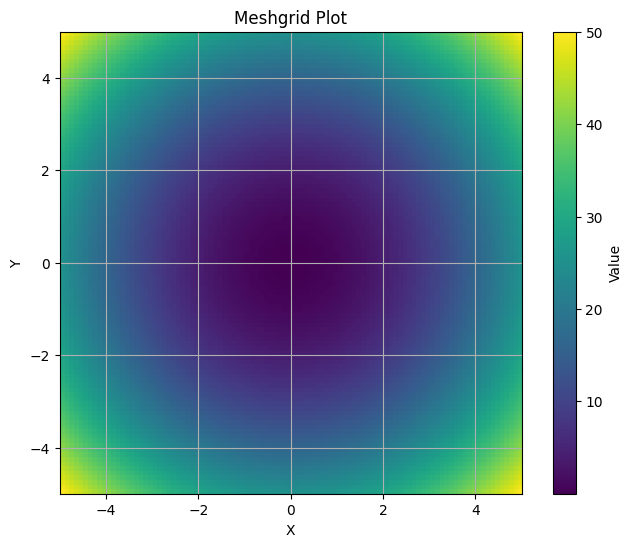

In [24]:
exact_data = sp.io.loadmat('burgers_shock.mat')
exact_time = exact_data['t'].flatten()[:]
exact_x = exact_data['t'].flatten()[:]

# Define the range and resolution of the meshgrid
x = np.linspace(-5, 5, 100)
y = np.linspace(-5, 5, 100)

# Generate the meshgrid
X, Y = np.meshgrid(x, y)

# Define the function to plot (for example, the squared distance from the origin)
Z = X**2 + Y**2

# Plot the meshgrid using plt.imshow()
plt.figure(figsize=(8, 6))
plt.imshow(Z, extent=(-5, 5, -5, 5), origin='lower', cmap='viridis')
plt.colorbar(label='Value')
plt.title('Meshgrid Plot')
plt.xlabel('X')
plt.ylabel('Y')
plt.grid(True)
plt.show()


In [26]:
import tensorflow as tf
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
os.environ['TF_ENABLE_ONEDNN_OPTS'] = '0'
from keras.models import Sequential
from tqdm.notebook import tqdm
from keras.layers import Dense
from numpy import pi
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
print(tf.config.list_physical_devices('GPU'))

def createTraj():
  fhat = Sequential()
  fhat.add(Dense(50, activation="tanh", input_dim=4))
  fhat.add(Dense(2))
  return fhat

u = createTraj()

Num GPUs Available:  1
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [27]:
number_train_pts = 20
x = tf.cast(tf.linspace(-1,1,number_train_pts),dtype=tf.float32)
t = tf.cast(tf.linspace(0,1,number_train_pts),dtype=tf.float32)
# input_vector = tf.stack((x,t))
# print(input_vector.shape)
def error(t,x):
  with tf.GradientTape(persistent=True) as tape:
    tape.watch(x)
    tape.watch(t)
    U = u(t,x)
  U_t = tape.gradient(U,t)
  U_x = tape.gradient(U,x)
  U_xx = tape.gradient(U_x,x)

  # Error in boundaries
  condition_1 = U[0,:] + np.sin(np.pi*x)
  condition_2 = U[:,-1]
  condition_3 = U[:,1]
  error_BC = condition_1**2 + condition_2**2 + condition_3**2

  # Error in Burger's equation
  burger_equation = U_t + U*U_x - (0.01/np.pi)*U_xx
  error_burger = burger_equation**2

  return error_BC + error_burger

In [28]:
run_counter = 0
tolerance = 1e-3
while error(t,x) >= tolerance:
  number_iterations_per_run = 300
  run_counter += 1
  if run_counter == 10:
    print('Failed to converge')
    break
  if error(t,x) <= tolerance*10**4:
    optimizer = tf.keras.optimizers.legacy.Adam(learning_rate=tolerance*10)
  elif error(t,x) <= 0.5*tolerance*10**4:
    optimizer = tf.keras.optimizers.legacy.Adam(learning_rate=tolerance*10**-2)
  elif error(t,x) <= tolerance*10**3:
    optimizer = tf.keras.optimizers.legacy.Adam(learning_rate=tolerance*10**-3)
  elif error(t,x) <= tolerance*10**2:
    optimizer = tf.keras.optimizers.legacy.Adam(learning_rate=tolerance*10**-4)
  elif error(t,x) <= tolerance*10:
    optimizer = tf.keras.optimizers.legacy.Adam(learning_rate=tolerance*10**-5)
  else:
    optimizer = tf.keras.optimizers.legacy.Adam(learning_rate=0.1)
  for i in tqdm(range(number_iterations_per_run),desc=f"Training run {run_counter}"):
    with tf.GradientTape(persistent=True) as tape:
      e = error(t,x)
    if e <= tolerance:
      print('Finish Training')
      break
  
  # Updating u
    grads = tape.gradient(e, u.trainable_variables)
    optimizer.apply_gradients(zip(grads,u.trainable_variables))
  print(f"Last error: {round(float(error(t,x)[0]),4)}")

ValueError: Exception encountered when calling layer 'sequential_4' (type Sequential).

Input 0 of layer "dense_8" is incompatible with the layer: expected min_ndim=2, found ndim=1. Full shape received: (20,)

Call arguments received by layer 'sequential_4' (type Sequential):
  • inputs=tf.Tensor(shape=(20,), dtype=float32)
  • training=tf.Tensor(shape=(20,), dtype=float32)
  • mask=None

In [ ]:
class YouCanHaveCheeseBorger:
  def __init__(self) -> None:
    return NotImplementedError
  